In [45]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import numpy as np
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm_notebook as tqdm
from tensorflow.contrib import slim
from IPython import display

In [ ]:
# graph = tf.Graph()
sess = tf.InteractiveSession()

In [30]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_labels = tf.one_hot(train_labels, depth=10).eval()

In [31]:
train_images = train_images.reshape(train_images.shape[0], 28*28).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28*28).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [32]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

In [33]:
imgs_dataset_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 28*28], name='img_dataset')
classes_dataset_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='cls_dataset')

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((imgs_dataset_placeholder, classes_dataset_placeholder))

In [35]:
data_iterator = dataset.shuffle(len(train_images)).batch(32).repeat().make_initializable_iterator()

In [36]:
input_img, input_class = data_iterator.get_next()

In [37]:
def encoder(x, c):
    with tf.variable_scope('encoder'):
        x = tf.concat([x,c], axis=-1)
        x = slim.fully_connected(x, 256, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 128, activation_fn=tf.nn.relu)
        mu = slim.fully_connected(x, 32, activation_fn=None)
        sigma = slim.fully_connected(x, 32, activation_fn=tf.nn.softplus)
        return mu, sigma
    
    
def decoder(x, c):
    with tf.variable_scope('decoder'):
        x = tf.concat([x,c], axis=-1) 
        x = slim.fully_connected(x, 128, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 256, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 28*28, activation_fn=None)
        return x
    
    
class CVAE:
    
    def __init__(self, x, c):
        with tf.variable_scope('vae', reuse=tf.AUTO_REUSE):
            self.x = x
            self.c = c
            self.mu, self.sigma = encoder(x,c)
            self.q_z = tf.distributions.Normal(self.mu, self.sigma)
            self.q_z_sample = self.q_z.sample()
            
            self.p_z = tf.distributions.Normal(0.0, 1.0)
            
            self.x_z = decoder(self.q_z_sample, c)
            self.x_z_distribution = tf.distributions.Bernoulli(logits=self.x_z)
            self.x_z_sample = self.x_z_distribution.sample()
            self._loss = None
        
    
    @property
    def loss(self):
        if self._loss is None:
            self.kl = tf.reduce_sum(tf.distributions.kl_divergence(self.p_z, self.q_z), axis=1)
            self.log_likelihood = tf.reduce_sum(self.x_z_distribution.log_prob(self.x), axis=1)
            elbo = tf.reduce_mean(self.log_likelihood - self.kl)
            self._loss = -elbo
        return self._loss
    
        

In [38]:
cvae = CVAE(input_img, input_class)

In [42]:
with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cvae.loss)

In [43]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [44]:
sess.run(data_iterator.initializer, feed_dict={imgs_dataset_placeholder: train_images, 
                                               classes_dataset_placeholder:train_labels}) 

In [87]:
epochs = 20
for epoch in range(1, epochs + 1):
    start_time = time.time()
    all_elbos = []
    all_kl = []
    all_logl = []
    cnt = 0
    try:
        for i in tqdm(range(60000/32)):
            _, elbo_value, kl, logl = sess.run([train_op, cvae.loss, cvae.kl, cvae.log_likelihood])
            all_elbos.append(elbo_value)
            all_kl.append(kl)
            all_logl.append(logl)
            cnt +=1
    except tf.errors.OutOfRangeError:
        pass
        
    end_time = time.time()

#     display.clear_output(wait=False)
    print('Epoch: {}, ELBO: {},  KL: {}, LogLikelihood: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    np.mean(all_elbos), np.mean(all_kl), np.mean(all_logl),
                                                    end_time - start_time))
    
    all_elbos = []


Epoch: 1, ELBO: 110.379463196,  KL: 20.1711902618, LogLikelihood: -90.2082824707, time elapse for current epoch 8.14920496941



Epoch: 2, ELBO: 109.685424805,  KL: 20.214263916, LogLikelihood: -89.4711608887, time elapse for current epoch 8.50358510017



Epoch: 3, ELBO: 109.113037109,  KL: 20.3185005188, LogLikelihood: -88.7945251465, time elapse for current epoch 8.35385799408



Epoch: 4, ELBO: 108.522483826,  KL: 20.3528881073, LogLikelihood: -88.1696014404, time elapse for current epoch 8.55152201653



Epoch: 5, ELBO: 108.063652039,  KL: 20.4346733093, LogLikelihood: -87.6289749146, time elapse for current epoch 8.29838895798



Epoch: 6, ELBO: 107.532218933,  KL: 20.5049877167, LogLikelihood: -87.0272216797, time elapse for current epoch 8.39245200157



Epoch: 7, ELBO: 107.140296936,  KL: 20.5774078369, LogLikelihood: -86.5628890991, time elapse for current epoch 8.50771188736



Epoch: 8, ELBO: 106.679130554,  KL: 20.611579895, LogLikelihood: -86.067565918, time elapse for current epoch 8.40681004524



Epoch: 9, ELBO: 106.253852844,  KL: 20.6605205536, LogLikelihood: -85.5933303833, time elapse for current epoch 8.44072413445



Epoch: 10, ELBO: 105.852180481,  KL: 20.7175140381, LogLikelihood: -85.1346664429, time elapse for current epoch 8.55823802948



Epoch: 11, ELBO: 105.487434387,  KL: 20.7391300201, LogLikelihood: -84.748298645, time elapse for current epoch 8.40969610214



Epoch: 12, ELBO: 105.129005432,  KL: 20.7866706848, LogLikelihood: -84.3423309326, time elapse for current epoch 8.65592503548



Epoch: 13, ELBO: 104.771102905,  KL: 20.8262500763, LogLikelihood: -83.9448471069, time elapse for current epoch 8.65221786499



Epoch: 14, ELBO: 104.387031555,  KL: 20.8428497314, LogLikelihood: -83.5441818237, time elapse for current epoch 8.39143586159



Epoch: 15, ELBO: 104.160797119,  KL: 20.9101524353, LogLikelihood: -83.2506484985, time elapse for current epoch 8.65206599236



Epoch: 16, ELBO: 103.740570068,  KL: 20.9266433716, LogLikelihood: -82.8139266968, time elapse for current epoch 8.54124999046



Epoch: 17, ELBO: 103.524116516,  KL: 20.9736690521, LogLikelihood: -82.5504608154, time elapse for current epoch 8.0859940052



Epoch: 18, ELBO: 103.167709351,  KL: 21.0115680695, LogLikelihood: -82.1561431885, time elapse for current epoch 8.66031098366



Epoch: 19, ELBO: 102.895492554,  KL: 21.0281333923, LogLikelihood: -81.8673477173, time elapse for current epoch 8.65128493309



Epoch: 20, ELBO: 102.709030151,  KL: 21.0734519958, LogLikelihood: -81.6355819702, time elapse for current epoch 8.55026316643


In [88]:
test_img = tf.placeholder(dtype=np.float32, shape=(1,28*28))
test_label = tf.placeholder(dtype=np.float32, shape=(1,10))

2

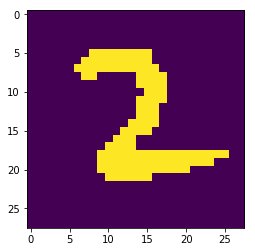

In [89]:
import random

idx = random.randint(0,1000)
img = train_images[idx].reshape(28,28)
label = train_labels[idx]
plt.imshow(img)
label.argmax()

In [90]:
test_vae = CVAE(test_img, test_label)

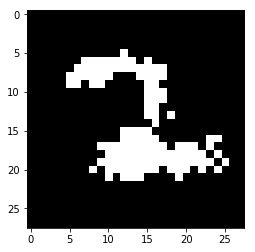

In [96]:
img_res, mu, sigma = sess.run([test_vae.x_z_sample, test_vae.mu, test_vae.sigma], 
                              feed_dict={test_vae.x: img.reshape(1,28*28), test_vae.c: label[np.newaxis]})
plt.imshow(img_res.reshape(28,28), cmap='gray')

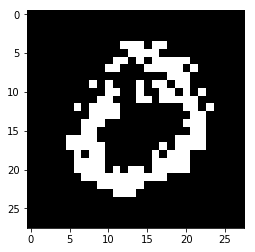

In [140]:
label = np.zeros(10)
label[0] = 1.0
img = sess.run(test_vae.x_z_sample, feed_dict={test_vae.q_z_sample: np.random.randn(1,32), 
                                               test_vae.c: label[np.newaxis]}).reshape((28,28))
plt.imshow(img, cmap='gray')